## Installing the transformers library
This is a package that contains the BERT model implementation along with other similar models as well. Restart kernel after installation.

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 8.5 MB/s 
     |████████████████████████████████| 6.8 MB 42.0 MB/s 
     |████████████████████████████████| 895 kB 15.5 MB/s 
     |████████████████████████████████| 67 kB 3.0 MB/s 
     |████████████████████████████████| 596 kB 18.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Imports
Next, we need to import all the needed libraries

In [1]:
from transformers import AutoTokenizer,AutoModel
from torch.utils.data import DataLoader,Dataset
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Input
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from matplotlib import pyplot as plt
import torch
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import backend as K
import numpy as np
import pandas as pd
import tensorflow as tf

## Loading the model


In [2]:
model_name = ["pdelobelle/robbert-v2-dutch-base", 'GroNLP/bert-base-dutch-cased'][1]
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/254 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/417M [00:00<?, ?B/s]

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.poole

## Reading the data 
We read the main dataset from the imported csv file.

In [3]:
data = pd.read_csv("http://modelingcreativity.org/data/aut_categorizedRaters.csv", encoding = 'latin-1')

In [4]:
data.head()

,research_id,response_id,respondent_id,object,original_response,cleaned_response,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63
0,CES201610,10063.0,648,brick,aambeeld,aambeeld,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,CES201610,5801.0,363,brick,het aanleggen van een weg,aanleggen weg,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CES201610,3973.0,237,brick,aannemen,aannemen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,CES201610,5226.0,300,brick,aannemer,aannemer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,CES201610,8321.0,555,brick,aarde,aarde,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We read the data from the raters' files.

In [5]:
raters_1 = pd.read_csv('http://modelingcreativity.org/data/brickcat_rater1.csv', encoding = 'latin-1').drop_duplicates(['original_response'])
responses_1 = raters_1['original_response'].to_list()
targets_1 = np.array([raters_1["cat_"+str(i)].to_list() for i in range(64)]).T

In [6]:
raters_2 = pd.read_csv('http://modelingcreativity.org/data/brickcat_rater2.csv', encoding = 'latin-1').drop_duplicates(['original_response'])
responses_2 = raters_2['original_response'].to_list()
targets_2 = np.array([raters_2["cat_"+str(i)].to_list() for i in range(64)]).T

In [7]:
raters_3 = pd.read_csv('http://modelingcreativity.org/data/brickcat_rater3.csv', encoding = 'latin-1').drop_duplicates(['original_response'])
responses_3 = raters_3['original_response'].to_list()
targets_3 = np.array([raters_3["cat_"+str(i)].to_list() for i in range(64)]).T

In [11]:
len(responses_1)

755

Extract only the responses that are not in the raters' datasets to feed into the algorithm.

In [12]:
remaining_data = data[~data['original_response'].isin(responses_1+responses_2+responses_3).to_numpy()]

In [13]:
remaining_data.head()

,research_id,response_id,respondent_id,object,original_response,cleaned_response,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63
2,CES201610,3973.0,237,brick,aannemen,aannemen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,CES201610,5226.0,300,brick,aannemer,aannemer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,CES201610,8321.0,555,brick,aarde,aarde,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,CES201610,9611.0,612,brick,accesoire,accessoire,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,CES201610,4144.0,249,brick,als accesoire,accessoire,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [14]:
remaining_data.shape

(4467, 70)

In [15]:
responses = remaining_data['original_response'].to_list()
categories = np.array([remaining_data["C"+str(i)].to_list() for i in range(64)]).T

In [16]:
#responses = data['original_response'].to_list()
#targets = np.array([data["C"+str(i)].to_list() for i in range(64)]).T
## This can be used instead if you don't want to remove any of the responses from the main dataframe

In [17]:
len(responses)
#remaining number of responses to be used

4467

## Creating the dataset and dataloader for generating embeddings

In [18]:
encodings = tokenizer.batch_encode_plus(responses,return_tensors='pt',max_length=120,truncation=True,padding='max_length')

In [19]:
class Response(Dataset):
    def __init__(self, encodings, labels, tokenizer):
        self.encodings = encodings
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return self.encodings["input_ids"].shape[0]

    def __getitem__(self, idx):
        item = dict()
        item['attention_mask'] = torch.tensor(self.encodings['attention_mask'][idx].numpy())
        item['input_ids'] = torch.tensor(self.encodings['input_ids'][idx].numpy()) 
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [20]:
response_dataset = Response(encodings,categories,tokenizer)
dataloader = DataLoader(response_dataset, batch_size=16, shuffle=True)

In [21]:
response_dataset[0]

{'attention_mask': tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([   1, 7965,    2,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,  

In [22]:
next(iter(dataloader))

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[    1, 14719,     2,  ...,     3,     3,     3],
         [    1, 18715,     2,  ...,     3,     3,     3],
         [    1, 13479,     2,  ...,     3,     3,     3],
         ...,
         [    1, 16237, 16804,  ...,     3,     3,     3],
         [    1, 15854,  9829,  ...,     3,     3,     3],
         [    1, 12806,     2,  ...,     3,     3,     3]]),
 'labels': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0]])}

## Generating the embeddings

After creating the dataset, we use the pre-trained model to generate sentence embeddings. We pass each sentence in the input through the model and get a vector of size (786).

We use 'cuda' to accelerate training using PyTorch. To check if your platform can use this, use the following command: torch.cuda.is_available(). Easiest way is to import this notebook to a colab file, and utilize the GPU hardware accelerator.

In [23]:
bert_model = bert_model.cuda()

In [24]:
embeddings = []

In [25]:
for batch in dataloader:
    with torch.no_grad():
        output = bert_model(batch['input_ids'].cuda())
        embeddings += [(output[1].cpu().detach().unsqueeze(0),batch['labels'])]
        

In [26]:
len(embeddings) # Number of batches

280

In [27]:
X = torch.cat([item[0] for item in embeddings], axis=1)[0]
y = torch.cat([item[1] for item in embeddings], axis=0)

In [28]:
X.shape,y.shape

(torch.Size([4467, 768]), torch.Size([4467, 64]))

## Saving embeddings to disk

In [29]:
torch.save(X,'X.pt')
torch.save(y,'y.pt')

In [30]:
X = torch.load('X.pt').numpy()
y = torch.load('y.pt').numpy()

In [31]:
X.shape,y.shape

((4467, 768), (4467, 64))

## Train test split

Divide into training (90%) and testing (10%) set, so that we have a set to test the final model's unbiased performance. The training set is further divided into a training (90%) and validation (10%) set to find the best model. We shuffle the data to get a random split, and also set a seed for reproducability.

In [32]:
X_interm, X_test, y_interm, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_interm, y_interm, test_size=0.1, random_state=42, shuffle=True)

In [33]:
X_train.shape,X_val.shape,X_test.shape

((3618, 768), (402, 768), (447, 768))

## Training a simple neural network

### Defining metrics

Create an f1 score function to add as a metric to the keras NN, as it is not available by default.

In [34]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Training parameters

In [35]:
LEARNING_RATE = 0.05 #@param {type:"number"}
BATCH_SIZE = 256 #@param {type:"integer"}
EPOCHS = 200 #@param {type:"integer"}

In [36]:
def model_function ():
  global LEARNING_RATE
  input_ids = Input(shape=(768,), name='input_ids', dtype='float')
  output = Dense(64, activation = 'sigmoid')(input_ids)
  model = Model(inputs= input_ids, outputs=output, name='BERT_MultiLabel_MultiClass')
  model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(LEARNING_RATE), metrics=['categorical_accuracy',f1])
  return model

In [37]:
model = model_function ()
history = model.fit(X_train,y_train, validation_data = (X_val, y_val), epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/200
15/15 [==============================] - 4s 23ms/step - loss: 0.4438 - categorical_accuracy: 0.2443 - f1: 0.1117 - val_loss: 0.4603 - val_categorical_accuracy: 0.0423 - val_f1: 0.0356
Epoch 2/200
15/15 [==============================] - 0s 7ms/step - loss: 0.3668 - categorical_accuracy: 0.2485 - f1: 0.1975 - val_loss: 0.2868 - val_categorical_accuracy: 0.2935 - val_f1: 0.1805
Epoch 3/200
15/15 [==============================] - 0s 6ms/step - loss: 0.2336 - categorical_accuracy: 0.2814 - f1: 0.2667 - val_loss: 0.1956 - val_categorical_accuracy: 0.3308 - val_f1: 0.3400
Epoch 4/200
15/15 [==============================] - 0s 7ms/step - loss: 0.1627 - categorical_accuracy: 0.3320 - f1: 0.2969 - val_loss: 0.1286 - val_categorical_accuracy: 0.3582 - val_f1: 0.2429
Epoch 5/200
15/15 [==============================] - 0s 8ms/step - loss: 0.1174 - categorical_accuracy: 0.3585 - f1: 0.2971 - val_loss: 0.0975 - val_categorical_accuracy: 0.3134 - val_f1: 0.2871
Epoch 6/200
15/15 [=====

## Visualization of results

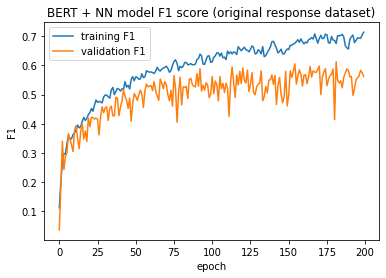

In [38]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('BERT + NN model F1 score (original response dataset)')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['training F1', 'validation F1'], loc='upper left')
plt.show()

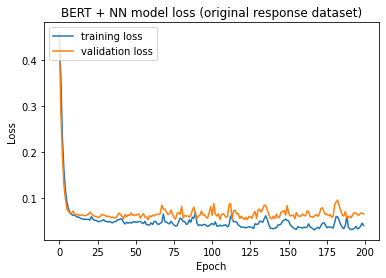

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BERT + NN model loss (original response dataset)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.show()

## Evaluation on the validation set

In [41]:
predictions = model.predict(X_val)
predictions = (predictions > 0.5)
accuracy    = accuracy_score(y_val, predictions)
precision   = precision_score(y_val, predictions, average = 'micro')
recall      = recall_score(y_val, predictions, average = 'micro')
f1_         = f1_score(y_val, predictions, average = 'micro')
hl          = hamming_loss(y_val, predictions)

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F-1:", round(f1_, 3))
print("Hamming Loss:", round(hl, 5))

Accuracy: 0.448
Precision: 0.697
Recall: 0.466
F-1: 0.559
Hamming Loss: 0.01302


## Evaluation on the test set

In [42]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5)
accuracy    = accuracy_score(y_test, predictions)
precision   = precision_score(y_test, predictions, average = 'micro')
recall      = recall_score(y_test, predictions, average = 'micro')
f1_         = f1_score(y_test, predictions, average = 'micro')
hl          = hamming_loss(y_test, predictions)

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F-1:", round(f1_, 3))
print("Hamming Loss:", round(hl, 5))

Accuracy: 0.47
Precision: 0.719
Recall: 0.518
F-1: 0.602
Hamming Loss: 0.01168


In [43]:
## Print the precision, recall, and f1-score for each category (0 to 63)
test_report = metrics.classification_report(y_test, predictions, digits=3)
print(test_report)

              precision    recall  f1-score   support

           0      0.889     0.182     0.302        44
           1      0.849     0.901     0.874       131
           2      0.778     1.000     0.875        14
           3      0.000     0.000     0.000         2
           4      1.000     0.200     0.333         5
           5      0.893     0.833     0.862        30
           6      0.000     0.000     0.000        14
           7      0.750     0.429     0.545         7
           8      0.000     0.000     0.000         1
           9      0.200     0.500     0.286         2
          10      0.000     0.000     0.000         2
          11      0.111     0.083     0.095        12
          12      0.000     0.000     0.000         2
          13      0.333     0.125     0.182         8
          14      0.000     0.000     0.000         3
          15      0.000     0.000     0.000         2
          16      0.000     0.000     0.000         0
          17      0.333    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


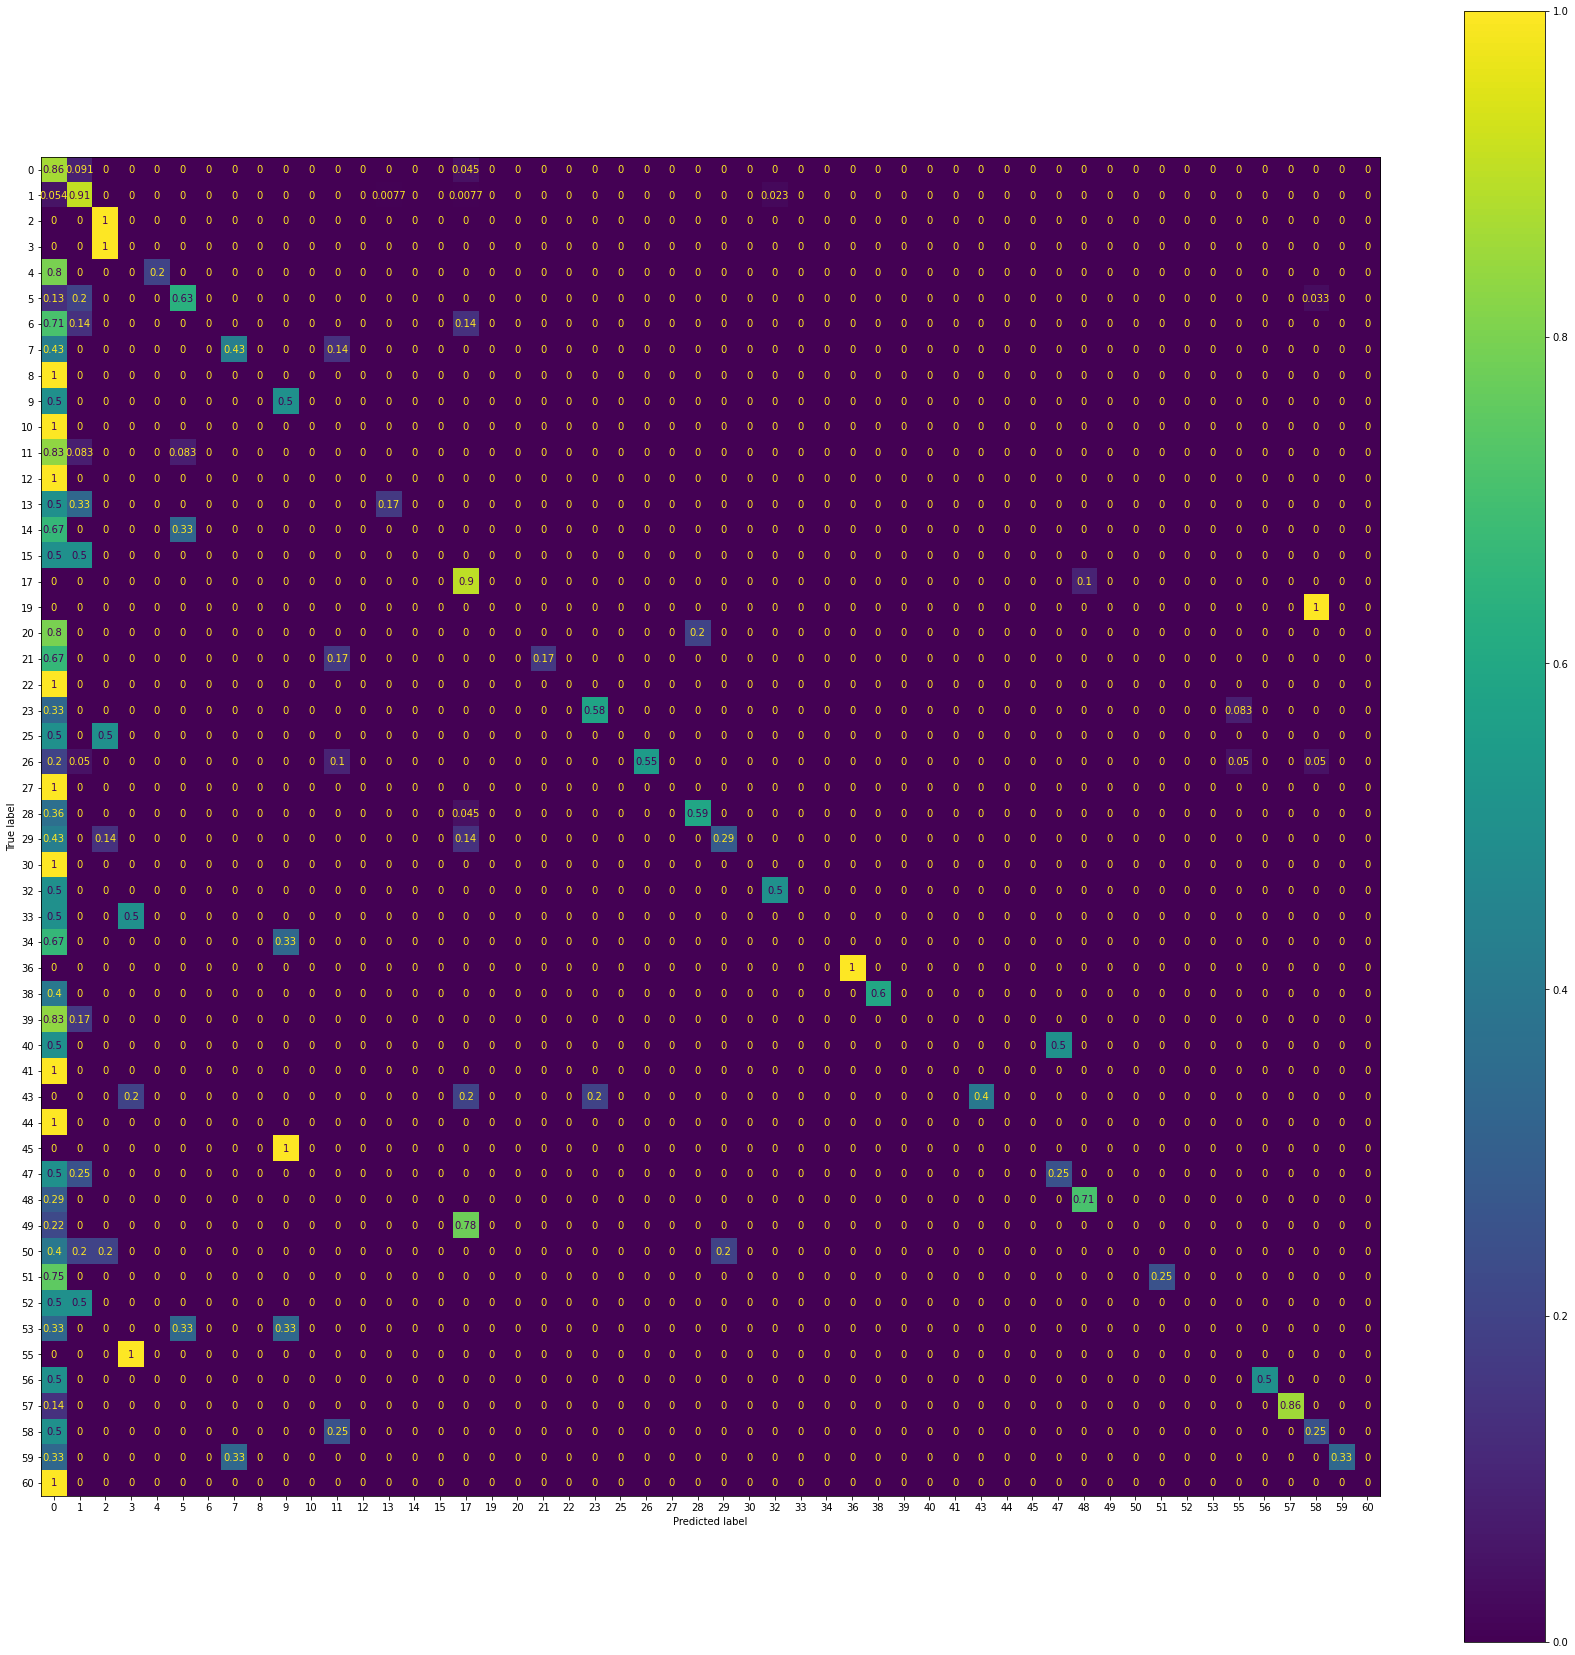

In [44]:
fig, ax = plt.subplots(figsize=(30, 30))
cm = metrics.ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), predictions.argmax(axis=1), ax=ax, normalize = 'true')

## Rater vs Rater Comparison

Hamming loss scores for all raters between each other.

In [45]:
# Rater 1 vs Rater 2
rater01_02   = hamming_loss(targets_1, targets_2)

# Rater 1 vs Rater 3
rater01_03   = hamming_loss(targets_1, targets_3)

# Rater 2 vs Rater 3
rater02_03   = hamming_loss(targets_2, targets_3)

print("Rater 1 vs Rater 2:")
print("Hamming Loss:", round(rater01_02, 5))
print()
print("Rater 1 vs Rater 3:")
print("Hamming Loss:", round(rater01_03, 5))
print()
print("Rater 2 vs Rater 3:")
print("Hamming Loss:", round(rater02_03, 5))


Rater 1 vs Rater 2:
Hamming Loss: 0.02713

Rater 1 vs Rater 3:
Hamming Loss: 0.02945

Rater 2 vs Rater 3:
Hamming Loss: 0.02533


## Rater  vs BERT + NN Algorithm

Evaluation of the BERT + NN algorithm using predictions based on the raters' sets. Hamming loss scores between each rater's category codings and the algorithm predictions of the categories based on the responses in the raters' files are extracted.

BERT embeddings of the responses in the rater 1's file.

In [46]:
encodings_1 = tokenizer.batch_encode_plus(responses_1,return_tensors='pt',max_length=120,truncation=True,padding='max_length')
response_dataset_1 = Response(encodings_1,targets_1,tokenizer)
dataloader_1 = DataLoader(response_dataset_1, batch_size=16, shuffle=True)
embeddings_1 = []
for batch in dataloader_1:
    with torch.no_grad():
        output = bert_model(batch['input_ids'].cuda())
        embeddings_1 += [(output[1].cpu().detach().unsqueeze(0),batch['labels'])]
        
X_1 = torch.cat([item[0] for item in embeddings_1], axis=1)[0]

BERT embeddings of the responses in the rater 2's file.


In [47]:
encodings_2 = tokenizer.batch_encode_plus(responses_2,return_tensors='pt',max_length=120,truncation=True,padding='max_length')
response_dataset_2 = Response(encodings_2,targets_2,tokenizer)
dataloader_2 = DataLoader(response_dataset_2, batch_size=16, shuffle=True)
embeddings_2 = []
for batch in dataloader_2:
    with torch.no_grad():
        output = bert_model(batch['input_ids'].cuda())
        embeddings_2 += [(output[1].cpu().detach().unsqueeze(0),batch['labels'])]
        
X_2 = torch.cat([item[0] for item in embeddings_2], axis=1)[0]

BERT embeddings of the responses in the rater 3's file.

In [48]:
encodings_3 = tokenizer.batch_encode_plus(responses_3,return_tensors='pt',max_length=120,truncation=True,padding='max_length')
response_dataset_3 = Response(encodings_3,targets_3,tokenizer)
dataloader_3 = DataLoader(response_dataset_3, batch_size=16, shuffle=True)
embeddings_3 = []
for batch in dataloader_3:
    with torch.no_grad():
        output = bert_model(batch['input_ids'].cuda())
        embeddings_3 += [(output[1].cpu().detach().unsqueeze(0),batch['labels'])]
        
X_3 = torch.cat([item[0] for item in embeddings_3], axis=1)[0]

In [49]:
predictions_1 = model.predict(X_1.numpy())
predictions_1 = (predictions_1 > 0.5) 

predictions_2 = model.predict(X_2.numpy())
predictions_2 = (predictions_2 > 0.5) 

predictions_3 = model.predict(X_3.numpy())
predictions_3 = (predictions_3 > 0.5) 

In [50]:
# Rater 1 vs Algorithm
rater01_hl = hamming_loss(targets_1, predictions_1)

# Rater 1 vs Algorithm
rater02_hl = hamming_loss(targets_2, predictions_2)

# Rater 3 vs Algorithm
rater03_hl = hamming_loss(targets_3, predictions_3)


print("Rater 1 vs Algorithm:", round(rater01_hl, 5))
print("Rater 2 vs Algorithm:", round(rater02_hl, 5))
print("Rater 3 vs Algorithm:", round(rater03_hl, 5))

Rater 1 vs Algorithm: 0.0424
Rater 2 vs Algorithm: 0.037
Rater 3 vs Algorithm: 0.03514
